In [21]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

# Data treatment
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
import pickle

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Embedding classifiers
#from skmultilearn.embedding import OpenNetworkEmbedder, CLEMS, SKLearnEmbedder
#from sklearn.manifold import SpectralEmbedding
#from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
#from skmultilearn.embedding import EmbeddingClassifier
#from sklearn.ensemble import RandomForestRegressor

from utils import KunischMetrics
from utils import KunischPruner
from utils import DataExplorer
from utils import KunischPlotter

import os

In [22]:
DS_FLAGS = ['base',
           'rot',
           'ref',
           'crop1',
           'elastic1',
           'randaug1',
           'gausblur1',
           'blur',
           'mtnblur',
          'rain', 
           'ref_rot',
           'rain_ref_rot',
           'rain_ref_rot_elastic1',
            'blur_rain_ref_rot_elastic1',
            'blur_rain_ref_rot_crop1_elastic1',
            'blur_rain_ref_rot_crop1_randaug1_elastic1'
           ]
folders_name = ['5L',
                '14L',
                '26L',
                '34L',
                '54L',
                '63L',
                '72L',
                '82L',
                '91L',
                '107L',
                '131L',
                '169L',
                '281L'
               ]

nlabels = [5, 14, 26, 34, 54, 63, 72, 82, 91, 107, 131, 169, 281]
targets = ['f2', 'recall', 'precision', 'hs', 'emr', 'mr5']

da_map = {
    'base': 0,
    'rot': 1,
    'ref': 2,
    'crop': 3,
    'elastic': 4,
    'rain': 5,
    'randaug': 6,
    'gausblur': 7,
    'blur': 8,
    'mtnblur': 9,
    'ref rot': 10,
    'rain ref rot': 11,
    'rain ref rot elastic': 12,
    'blur rain ref rot elastic': 13,
    'blur rain ref rot crop elastic': 14,
    'blur rain ref rot crop randaug elastic': 15,
}

In [58]:
target = 'f2'
target_name = 'Micro F2-Score'
use_alexnet = True
fuente = 'alexnet' if use_alexnet else 'images'
pp_fuente = 'AlexNet' if use_alexnet else 'Imágenes 40x40'

In [59]:
dic_tecnicas = {}
for tecnica in DS_FLAGS:
    dic_target = {}
    for target in targets:
        score_tecnica = []
        for cant_etiquetas in folders_name:
            scores_path = os.path.join('..', 'outputs', 'C2AE_' + fuente, tecnica, cant_etiquetas, 
                                       'metadata.csv')
            scores = pd.read_csv(scores_path, index_col = 0)
            score_tecnica.append(float(scores.loc[target].values[0]))
        dic_target[target] = score_tecnica
    dic_tecnicas[tecnica] = dic_target

df_total = None

for k, v in dic_tecnicas.items():
    df = pd.DataFrame.from_dict(v, orient='index', columns=nlabels)
    df = df.T
    k = k.replace('1', '')
    k = k.replace('_', ' ')
    df['conjunto'] = [da_map[k]] * len(nlabels)
    df['etiquetas'] = df.index
    df = df[['conjunto', 'etiquetas', 'f2', 'recall', 'precision', 'hs', 'emr', 'mr5']]
    df.index = pd.MultiIndex.from_arrays(df[['etiquetas', 'conjunto']].values.T, names=['etiquetas', 'conjunto'])

    if df_total is None:
        df_total = df
    else:
        df_total = pd.concat([df_total, df])
display(df_total)
df_total.to_csv('Tabla-E5.csv')

,,conjunto,etiquetas,f2,recall,precision,hs,emr,mr5
etiquetas,conjunto,,,,,,,,
5,0,0,5,0.6386,0.7800,0.3916,0.3577,0.0980,0.6843
14,0,0,14,0.4395,0.4975,0.3077,0.2543,0.0078,0.2783
26,0,0,26,0.4426,0.5264,0.2754,0.2306,0.0000,0.2255
34,0,0,34,0.4337,0.5571,0.2382,0.2032,0.0000,0.2203
54,0,0,54,0.4208,0.6157,0.1894,0.1706,0.0000,0.2332
...,...,...,...,...,...,...,...,...,...
91,15,15,91,0.3026,0.3897,0.1734,0.1412,0.0000,0.0670
107,15,15,107,0.3398,0.4218,0.1924,0.1582,0.0000,0.0490
131,15,15,131,0.3518,0.4449,0.1957,0.1623,0.0000,0.0683


In [60]:
import math
target = 'f2'
target_name = 'Micro F2-Score'
dic_tecnicas = {}
for tecnica in DS_FLAGS:
    score_tecnica = []
    for cant_etiquetas in folders_name:
        scores_path = os.path.join('..', 'outputs', 'C2AE_' + fuente, tecnica, cant_etiquetas, 
                                   'metadata.csv')
        scores = pd.read_csv(scores_path, index_col = 0)
        score_tecnica.append(float(scores.loc[target].values[0]))
    dic_tecnicas[tecnica] = score_tecnica
    #dic_tecnicas[tecnica] = [np.average(score_tecnica), np.var(score_tecnica)]
display(pd.DataFrame.from_dict(dic_tecnicas, orient='index', columns=nlabels))


#for k, v in dic_tecnicas.items():
#    sum = 0
#    for score in v:
#        sum -= score * math.log(score)
#    dic_tecnicas[k].append(sum)

#display(dic_tecnicas)
#df_var = pd.DataFrame.from_dict(dic_tecnicas, orient='index', columns=['Promedio', 'Varianza', 'Entropía'])
#df_var = df_var.sort_values(['Entropía','Varianza','Promedio'], axis=0, ascending=False)
#display(df_var)


,5,14,26,34,54,63,72,82,91,107,131,169,281
base,0.6386,0.4395,0.4426,0.4337,0.4208,0.4131,0.4064,0.3892,0.3847,0.3739,0.3603,0.3276,0.2698
rot,0.5029,0.4269,0.3554,0.3441,0.3566,0.3425,0.3544,0.3696,0.3533,0.3521,0.3438,0.3518,0.3190
ref,0.5895,0.3620,0.3461,0.3572,0.3657,0.3468,0.3477,0.3301,0.3253,0.3497,0.3330,0.3445,0.3116
crop1,0.5741,0.3439,0.3593,0.3864,0.3654,0.3598,0.3604,0.3300,0.3604,0.3586,0.3528,0.3598,0.3035
elastic1,0.5946,0.4038,0.3660,0.3912,0.3774,0.3699,0.3780,0.3664,0.3498,0.3534,0.3600,0.3427,0.3167
randaug1,0.5489,0.4129,0.3692,0.3785,0.3679,0.3671,0.3507,0.3746,0.3528,0.3607,0.3593,0.3524,0.3203
gausblur1,0.5140,0.3806,0.3563,0.3449,0.3340,0.3474,0.3668,0.3634,0.3445,0.3654,0.3495,0.3451,0.3237
blur,0.5877,0.3748,0.3867,0.3918,0.3641,0.3688,0.3797,0.3408,0.3564,0.3682,0.3565,0.3584,0.3166
mtnblur,0.5813,0.4069,0.3838,0.3770,0.3803,0.3746,0.3647,0.3458,0.3533,0.3503,0.3648,0.3607,0.3007
rain,0.6045,0.3912,0.3556,0.3696,0.3781,0.3779,0.3579,0.3662,0.3538,0.3775,0.3653,0.3609,0.3224


In [61]:
dic_tecnicas

{'base': [0.6386,
  0.4395,
  0.4426,
  0.4337,
  0.4208,
  0.4131,
  0.4064,
  0.3892,
  0.3847,
  0.3739,
  0.3603,
  0.3276,
  0.2698],
 'rot': [0.5029,
  0.4269,
  0.3554,
  0.3441,
  0.3566,
  0.3425,
  0.3544,
  0.3696,
  0.3533,
  0.3521,
  0.3438,
  0.3518,
  0.319],
 'ref': [0.5895,
  0.362,
  0.3461,
  0.3572,
  0.3657,
  0.3468,
  0.3477,
  0.3301,
  0.3253,
  0.3497,
  0.333,
  0.3445,
  0.3116],
 'crop1': [0.5741,
  0.3439,
  0.3593,
  0.3864,
  0.3654,
  0.3598,
  0.3604,
  0.33,
  0.3604,
  0.3586,
  0.3528,
  0.3598,
  0.3035],
 'elastic1': [0.5946,
  0.4038,
  0.366,
  0.3912,
  0.3774,
  0.3699,
  0.378,
  0.3664,
  0.3498,
  0.3534,
  0.36,
  0.3427,
  0.3167],
 'randaug1': [0.5489,
  0.4129,
  0.3692,
  0.3785,
  0.3679,
  0.3671,
  0.3507,
  0.3746,
  0.3528,
  0.3607,
  0.3593,
  0.3524,
  0.3203],
 'gausblur1': [0.514,
  0.3806,
  0.3563,
  0.3449,
  0.334,
  0.3474,
  0.3668,
  0.3634,
  0.3445,
  0.3654,
  0.3495,
  0.3451,
  0.3237],
 'blur': [0.5877,
  0.3748

In [62]:
AUCS = {}
for curva, valores in dic_tecnicas.items():
    auc = 0
    for i in range(len(valores)-1):
        score_init = valores[i]
        score_final = valores[i+1]
        low_score = min(score_init, score_final)
        high_score = max(score_init, score_final)
        rectangulo = low_score * (nlabels[i+1] - nlabels[i]) 
        triangulo = high_score * (nlabels[i+1] - nlabels[i])/2
        auc += rectangulo + triangulo
    AUCS[curva] = auc
AUCS

{'base': 145.06925,
 'rot': 143.26695,
 'ref': 139.72140000000002,
 'crop1': 142.76405,
 'elastic1': 145.2358,
 'randaug1': 146.02105,
 'gausblur1': 142.7036,
 'blur': 146.1469,
 'mtnblur': 144.98485,
 'rain': 147.57004999999998,
 'ref_rot': 138.47315,
 'rain_ref_rot': 138.32659999999998,
 'rain_ref_rot_elastic1': 136.08325000000002,
 'blur_rain_ref_rot_elastic1': 136.0255,
 'blur_rain_ref_rot_crop1_elastic1': 133.80919999999998,
 'blur_rain_ref_rot_crop1_randaug1_elastic1': 136.9731}

In [63]:
np.average(dic_tecnicas['base'])

0.4077076923076923

In [64]:
plt.rcParams.update({'font.size': 6})
plt.rcParams['figure.dpi'] = 300
plotter = KunischPlotter()

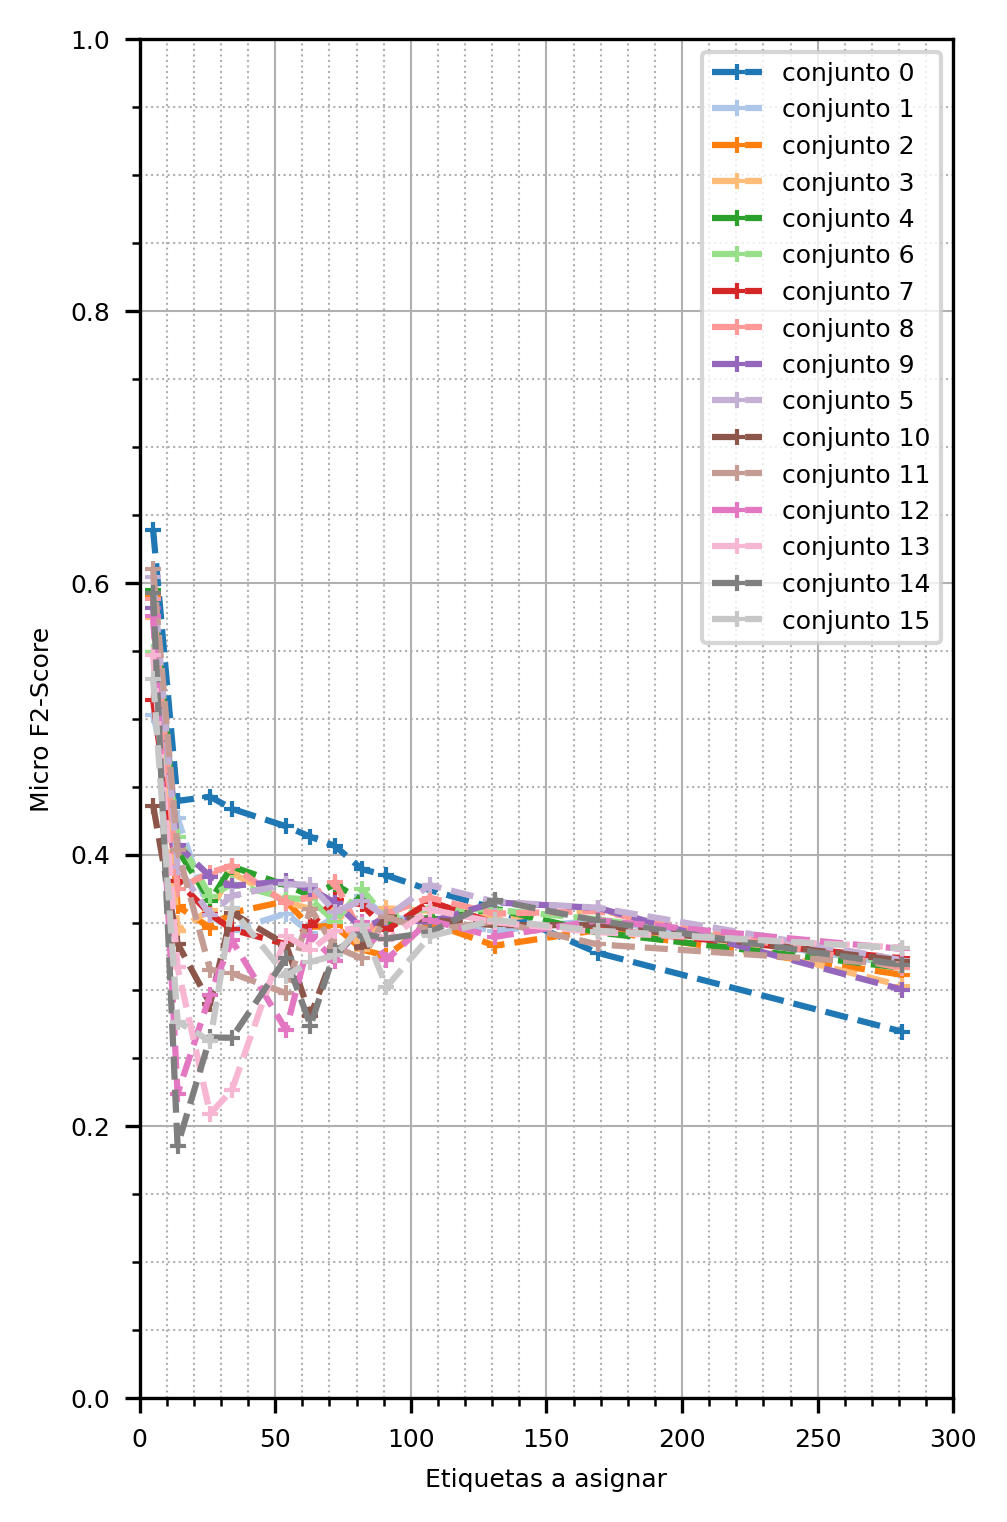

In [65]:
labels = list(dic_tecnicas.keys())
labels_pp = []

for label in labels:
    label = label.replace('1', '')
    label = label.replace('_', ' ')
    labels_pp.append('conjunto ' + str(da_map[label]))
    
plotter.plot_results(nlabels,
             score = list(dic_tecnicas.values()),
             label = labels_pp,
             #title = target_name + ' v/s Cantidad de Etiquetas\nDescriptores ' + pp_fuente,
             xlabel = "Etiquetas a asignar", ylabel = target_name,
             ylim = 1.0,
             xlim = 300,
             width = 3.5,
             height = 6,
             grid = True,
             minorgrid = True, 
             #order = [9, 0, 6, 3, 12, 2, 11, 13, 8, 5, 4, 1, 7, 10, 14, 15])
                    )
#              order = [0, 8, 12, 4, 1, 9, 13, 3, 7, 16, 17, 2, 14, 10, 5, 6, 15, 11, 18])